## Search Algorithms

So far we have been using Ray's basic/default Variant Generator in order to perform either:

 - Grid Search
 - Random Search
 
However, Raytune has an expanding suite of options available for different [Search Algortihms](https://docs.ray.io/en/latest/tune-searchalg.html):

 - BayesOpt
 - HyperOpt
 - SigOpt
 - Nevergrad
 - Scikit-Optimize
 - Ax
 - BOHB
 
These bolt in functionality from other well known libraries and make them avilable to us in Raytune. 

Depending on the library that we use there are some customisations needed to use it but these are not in our training code, but centered around how we define the `search space` and call `ray.run`.

### Switch to Bayesian Optimisation

Ray's BayesOpt uses the [bayesian-optimisation](https://github.com/fmfn/BayesianOptimization) package which is already installed in our conda environment





In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *
from seg_setup_code import *

Loading dependencies we have already seen...
Importing ray...
Done...


Rather than loading bayesopt directly we pull in the tune search algorithm tha wraps it

In [2]:
from ray.tune.suggest.bayesopt import BayesOptSearch

Next we have copied across the same training function from earlier notebooks.

In [3]:
from sklearn.model_selection import LeavePGroupsOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy.signal import medfilt
from filelock import FileLock

def e2e_train_and_test(config, **kwargs):
    
    # threadsafe
#     with FileLock("./data.lock"):
    X, y, groups, X_test, y_test, group_test, well_names = setup(kwargs['filepath'])
    
    # chose your CV strategy
    splitter = LeavePGroupsOut(1)
    
    # run k fold training and validation
    f1_scores = [] # keep hold of all individual scores
    for train_ind, val_ind in splitter.split(X, y, groups=groups):
        pipeline = make_pipeline(RobustScaler(),
                                  XGBClassifier())

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[val_ind])
        
        f1_scores.append(f1_score(y_pred, y[val_ind], average='micro'))
    
        # Clean isolated facies for each well
        y_pred = medfilt(y_pred, kernel_size=5)
    
    # use tunes reporter
    tune.track.log(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

#### Defining the Search Space

In previous examples we have creates the search space for our tuning job using Raytune's distribution functions.

In [4]:
ray_tuning_config = {
    'xgbclassifier__learning_rate': tune.loguniform(0.001, 0.5),
    'xgbclassifier__max_depth': tune.randint(1, 10),
    'xgbclassifier__min_child_weight': tune.loguniform(0.1, 10),
    'xgbclassifier__n_estimators': tune.randint(5,200),
    'xgbclassifier__colsample_bytree': tune.choice([0.4, 0.6, 0.8, 1.0]),
    'xgbclassifier__lambda': tune.choice([0,1]),
    'xgbclassifier__seed': 42
}

But when using BayesOpt we need to change this and specify:
 - the bounds of the parameter space `pbounds`
 - the form / parameters of a UtilityFunction
 - a modified config object
 
To start with we convert our tuning config to align with pbounds, which uses simple tuples and only suppports *continuous* spaces

In [4]:
pbounds = {
    "xgbclassifier__learning_rate": (0.001, 0.5),
    "xgbclassifier__max_depth": (1, 10),                # Needs to be integer!
    "xgbclassifier__min_child_weight": (0.1, 100),
    "xgbclassifier__n_estimators": (5, 200),            # Needs to be integer!
    "xgbclassifier__colsample_bytree": (0.4, 1.0),
    "xgbclassifier__lambda": (0, 1)                     # Needs to be true/false 1/0
}

def parse_config(config):
    config["xgbclassifier__max_depth"] = int(round(config["xgbclassifier__max_depth"]))
    config["xgbclassifier__n_estimators"] = int(round(config["xgbclassifier__n_estimators"]))
    config["xgbclassifier__lambda"] = int(round(config["xgbclassifier__lambda"]))
    return config

In [5]:
utility_fn_kwargs={
    "kind": "ucb",
    "kappa": 2.5,
    "xi": 0.0
}

In [6]:
search_algo = BayesOptSearch(
                pbounds,
                metric="mean_f1_score",
                mode="max",
                utility_kwargs=utility_fn_kwargs)

In [7]:
config = {
    # controls the number of trials
    "num_samples": 10,
    "config": {
        "xgbclassifier__seed": 42,
    },
    "stop": {
        "timesteps_total": 4
    }
}

In [8]:
ray.shutdown()
ray.init(num_cpus=6, num_gpus=0, include_webui=True)

2020-06-12 11:02:36,828	INFO resource_spec.py:204 -- Starting Ray with 32.91 GiB memory available for workers and up to 16.47 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-12 11:02:37,138	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:59090',
 'object_store_address': '/tmp/ray/session_2020-06-12_11-02-36_827633_134496/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-12_11-02-36_827633_134496/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-12_11-02-36_827633_134496'}

In [9]:
from os import path
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')

def e2e_seg(config):
    return e2e_train_and_test(config, filepath=filepath)

def e2e_seg_w_discrete(config):  
    return e2e_seg(
        parse_config(config)
    )

analysis = tune.run(e2e_seg_w_discrete,
                    name="seg_facies_bayes",
                    search_alg=search_algo,
                    **config)

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators
e2e_seg_w_discrete_e7ae679e,RUNNING,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006
e2e_seg_w_discrete_e7aec554,PENDING,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618
e2e_seg_w_discrete_e7aefc7c,PENDING,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945
e2e_seg_w_discrete_e7af2cec,PENDING,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003
e2e_seg_w_discrete_e7af5bfe,PENDING,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238
e2e_seg_w_discrete_e7af82be,PENDING,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255
e2e_seg_w_discrete_e7aface4,PENDING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892
e2e_seg_w_discrete_e7afd584,PENDING,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548
e2e_seg_w_discrete_e7aff6c2,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816
e2e_seg_w_discrete_e7b018a0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453


(pid=134779) 2020-06-12 11:03:04,362	INFO trainable.py:217 -- Getting current IP.
(pid=134782) 2020-06-12 11:03:04,362	INFO trainable.py:217 -- Getting current IP.
(pid=134781) 2020-06-12 11:03:04,436	INFO trainable.py:217 -- Getting current IP.
(pid=134780) 2020-06-12 11:03:04,477	INFO trainable.py:217 -- Getting current IP.
(pid=134783) 2020-06-12 11:03:04,439	INFO trainable.py:217 -- Getting current IP.
(pid=134784) 2020-06-12 11:03:04,486	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_e7ae679e:
  date: 2020-06-12_11-03-12
  done: true
  experiment_id: d42f05d5bc4a4d6d9dd206a3c8269fc0
  experiment_tag: 1_xgbclassifier__colsample_bytree=0.65021,xgbclassifier__lambda=0.72032,xgbclassifier__learning_rate=0.0010571,xgbclassifier__max_depth=3.721,xgbclassifier__min_child_weight=14.761,xgbclassifier__n_estimators=23.006,xgbclassifier__seed=42
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5211406416539359
  node_ip: 192.168.1.39
  pid: 1

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_e7ae679e,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,8.0618
e2e_seg_w_discrete_e7aec554,RUNNING,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,,
e2e_seg_w_discrete_e7aefc7c,RUNNING,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,,
e2e_seg_w_discrete_e7af2cec,RUNNING,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,,
e2e_seg_w_discrete_e7af5bfe,RUNNING,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,,
e2e_seg_w_discrete_e7af82be,RUNNING,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,,
e2e_seg_w_discrete_e7aface4,PENDING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_e7afd584,PENDING,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,,
e2e_seg_w_discrete_e7aff6c2,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_e7b018a0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,


(pid=134908) 2020-06-12 11:03:13,701	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_e7af82be:
  date: 2020-06-12_11-03-16
  done: true
  experiment_id: 0062752029864578b53ab3573666ee48
  experiment_tag: 6_xgbclassifier__colsample_bytree=0.45901,xgbclassifier__lambda=0.42111,xgbclassifier__learning_rate=0.47899,xgbclassifier__max_depth=5.7985,xgbclassifier__min_child_weight=69.219,xgbclassifier__n_estimators=66.526,xgbclassifier__seed=42
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5609907089304509
  node_ip: 192.168.1.39
  pid: 134781
  std_f1_score: 0.05607592989702095
  time_since_restore: 11.95385456085205
  time_this_iter_s: 11.95385456085205
  time_total_s: 11.95385456085205
  timestamp: 1591956196
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e7af82be
  
(pid=134965) 2020-06-12 11:03:17,503	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_e7af5bfe:
  date: 2020-06-12_11-03-25
  done

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_e7ae679e,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,8.0618
e2e_seg_w_discrete_e7aec554,RUNNING,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,,
e2e_seg_w_discrete_e7aefc7c,RUNNING,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,,
e2e_seg_w_discrete_e7af2cec,RUNNING,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,,
e2e_seg_w_discrete_e7af5bfe,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,21.3563
e2e_seg_w_discrete_e7af82be,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,11.9539
e2e_seg_w_discrete_e7aface4,RUNNING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_e7afd584,RUNNING,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,,
e2e_seg_w_discrete_e7aff6c2,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_e7b018a0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,


(pid=134990) 2020-06-12 11:03:27,013	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_e7afd584:
  date: 2020-06-12_11-03-32
  done: true
  experiment_id: 57a1a08b44bd485ea5388c0791be2719
  experiment_tag: 8_xgbclassifier__colsample_bytree=0.56827,xgbclassifier__lambda=0.78928,xgbclassifier__learning_rate=0.05251,xgbclassifier__max_depth=5.031,xgbclassifier__min_child_weight=90.869,xgbclassifier__n_estimators=62.255,xgbclassifier__seed=42
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.49779769083912806
  node_ip: 192.168.1.39
  pid: 134965
  std_f1_score: 0.1690603618343556
  time_since_restore: 14.731911420822144
  time_this_iter_s: 14.731911420822144
  time_total_s: 14.731911420822144
  timestamp: 1591956212
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e7afd584
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_e7ae679e,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,8.0618
e2e_seg_w_discrete_e7aec554,RUNNING,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,,
e2e_seg_w_discrete_e7aefc7c,RUNNING,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,,
e2e_seg_w_discrete_e7af2cec,RUNNING,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,,
e2e_seg_w_discrete_e7af5bfe,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,21.3563
e2e_seg_w_discrete_e7af82be,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,11.9539
e2e_seg_w_discrete_e7aface4,RUNNING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_e7afd584,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,14.7319
e2e_seg_w_discrete_e7aff6c2,RUNNING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_e7b018a0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,


(pid=135005) 2020-06-12 11:03:33,445	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_e7af2cec:
  date: 2020-06-12_11-03-38
  done: true
  experiment_id: 62f45553903c4e4a8414976b5b7963d8
  experiment_tag: 4_xgbclassifier__colsample_bytree=0.48423,xgbclassifier__lambda=0.1981,xgbclassifier__learning_rate=0.40057,xgbclassifier__max_depth=9.7144,xgbclassifier__min_child_weight=31.411,xgbclassifier__n_estimators=140.0,xgbclassifier__seed=42
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5636997517283613
  node_ip: 192.168.1.39
  pid: 134779
  std_f1_score: 0.08171500257000076
  time_since_restore: 33.808151960372925
  time_this_iter_s: 33.808151960372925
  time_total_s: 33.808151960372925
  timestamp: 1591956218
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e7af2cec
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_e7ae679e,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,8.0618
e2e_seg_w_discrete_e7aec554,RUNNING,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,,
e2e_seg_w_discrete_e7aefc7c,RUNNING,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,,
e2e_seg_w_discrete_e7af2cec,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,33.8082
e2e_seg_w_discrete_e7af5bfe,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,21.3563
e2e_seg_w_discrete_e7af82be,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,11.9539
e2e_seg_w_discrete_e7aface4,RUNNING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_e7afd584,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,14.7319
e2e_seg_w_discrete_e7aff6c2,RUNNING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_e7b018a0,RUNNING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,


Result for e2e_seg_w_discrete_e7aec554:
  date: 2020-06-12_11-03-38
  done: true
  experiment_id: 8acfc4942be542bb953b980233487f1f
  experiment_tag: 2_xgbclassifier__colsample_bytree=0.51176,xgbclassifier__lambda=0.34556,xgbclassifier__learning_rate=0.19899,xgbclassifier__max_depth=5.8494,xgbclassifier__min_child_weight=41.978,xgbclassifier__n_estimators=138.62,xgbclassifier__seed=42
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.565058383283766
  node_ip: 192.168.1.39
  pid: 134782
  std_f1_score: 0.06732102090864256
  time_since_restore: 34.592881202697754
  time_this_iter_s: 34.592881202697754
  time_total_s: 34.592881202697754
  timestamp: 1591956218
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e7aec554
  
Result for e2e_seg_w_discrete_e7aefc7c:
  date: 2020-06-12_11-03-39
  done: true
  experiment_id: ace8e9a9343d43209ec4b57dd8f18bc3
  experiment_tag: 3_xgbclassifier__colsample_bytree=0.52267,xgbclassifier__lambda=0.87812,xgbclassifier__

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_e7ae679e,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,8.0618
e2e_seg_w_discrete_e7aec554,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,34.5929
e2e_seg_w_discrete_e7aefc7c,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,35.0697
e2e_seg_w_discrete_e7af2cec,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,33.8082
e2e_seg_w_discrete_e7af5bfe,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,21.3563
e2e_seg_w_discrete_e7af82be,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,11.9539
e2e_seg_w_discrete_e7aface4,RUNNING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_e7afd584,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,14.7319
e2e_seg_w_discrete_e7aff6c2,RUNNING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_e7b018a0,TERMINATED,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,0,20.6134


Result for e2e_seg_w_discrete_e7aff6c2:
  date: 2020-06-12_11-03-54
  done: true
  experiment_id: f51f998fadfc416dbef8d46bfeb562a6
  experiment_tag: 9_xgbclassifier__colsample_bytree=0.57267,xgbclassifier__lambda=0.13003,xgbclassifier__learning_rate=0.010664,xgbclassifier__max_depth=7.1095,xgbclassifier__min_child_weight=21.242,xgbclassifier__n_estimators=56.782,xgbclassifier__seed=42
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5223762571210588
  node_ip: 192.168.1.39
  pid: 134990
  std_f1_score: 0.09325008118034692
  time_since_restore: 27.238328456878662
  time_this_iter_s: 27.238328456878662
  time_total_s: 27.238328456878662
  timestamp: 1591956234
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e7aff6c2
  
Result for e2e_seg_w_discrete_e7aface4:
  date: 2020-06-12_11-03-56
  done: true
  experiment_id: 91dc8d88d2a14fb5a5a3a611a08c83c7
  experiment_tag: 7_xgbclassifier__colsample_bytree=0.8119,xgbclassifier__lambda=0.83463,xgbclassifier_

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_e7ae679e,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,8.0618
e2e_seg_w_discrete_e7aec554,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,34.5929
e2e_seg_w_discrete_e7aefc7c,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,35.0697
e2e_seg_w_discrete_e7af2cec,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,33.8082
e2e_seg_w_discrete_e7af5bfe,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,21.3563
e2e_seg_w_discrete_e7af82be,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,11.9539
e2e_seg_w_discrete_e7aface4,TERMINATED,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,0,43.1869
e2e_seg_w_discrete_e7afd584,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,14.7319
e2e_seg_w_discrete_e7aff6c2,TERMINATED,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,0,27.2383
e2e_seg_w_discrete_e7b018a0,TERMINATED,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,0,20.6134


In [10]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'xgbclassifier__colsample_bytree': 0.5117561268266025,
 'xgbclassifier__lambda': 0.34556072704304774,
 'xgbclassifier__learning_rate': 0.1989869696411043,
 'xgbclassifier__max_depth': 5.849350606030212,
 'xgbclassifier__min_child_weight': 41.977531988889154,
 'xgbclassifier__n_estimators': 138.6178025773681,
 'xgbclassifier__seed': 42}


In [11]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

In [12]:
top_n_df.head()

,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,iterations_since_restore,experiment_tag,config/xgbclassifier__colsample_bytree,config/xgbclassifier__lambda,config/xgbclassifier__learning_rate,config/xgbclassifier__max_depth,config/xgbclassifier__min_child_weight,config/xgbclassifier__n_estimators,config/xgbclassifier__seed,logdir
1,0.565058,0.067321,True,e7aec554,0,34.592881,NaN,NaN,8acfc4942be542bb953b980233487f1f,2020-06-12_11-03-38,...,1,"2_xgbclassifier__colsample_bytree=0.51176,xgbc...",0.511756,0.345561,0.198987,5.849351,41.977532,138.617803,42,/home/steve/ray_results/seg_facies_bayes/e2e_s...
9,0.564428,0.059864,True,e7b018a0,0,20.613445,NaN,NaN,7c4d062ddc0545c9b94bdf948ffcb683,2020-06-12_11-03-54,...,1,"10_xgbclassifier__colsample_bytree=0.69494,xgb...",0.694944,0.053363,0.287485,2.320557,58.971623,141.452880,42,/home/steve/ray_results/seg_facies_bayes/e2e_s...
3,0.563700,0.081715,True,e7af2cec,0,33.808152,NaN,NaN,62f45553903c4e4a8414976b5b7963d8,2020-06-12_11-03-38,...,1,"4_xgbclassifier__colsample_bytree=0.48423,xgbc...",0.484232,0.198101,0.400572,9.714354,31.411075,140.002910,42,/home/steve/ray_results/seg_facies_bayes/e2e_s...
5,0.560991,0.056076,True,e7af82be,0,11.953855,NaN,NaN,0062752029864578b53ab3573666ee48,2020-06-12_11-03-16,...,1,"6_xgbclassifier__colsample_bytree=0.45901,xgbc...",0.459008,0.421108,0.478987,5.798488,69.218524,66.525548,42,/home/steve/ray_results/seg_facies_bayes/e2e_s...
2,0.539936,0.082248,True,e7aefc7c,0,35.069671,NaN,NaN,ace8e9a9343d43209ec4b57dd8f18bc3,2020-06-12_11-03-39,...,1,"3_xgbclassifier__colsample_bytree=0.52267,xgbc...",0.522671,0.878117,0.014666,7.034208,41.788750,113.944517,42,/home/steve/ray_results/seg_facies_bayes/e2e_s...


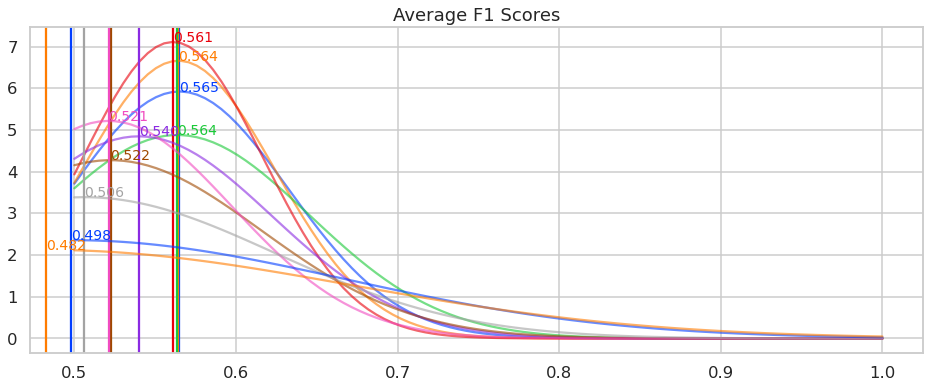

In [13]:
plot_some_tune_results(top_n_df, (0.5, 1.0))

In [14]:
param_cols = [
    'config/xgbclassifier__n_estimators',    
    'config/xgbclassifier__colsample_bytree',
    'config/xgbclassifier__lambda',
    'config/xgbclassifier__learning_rate',
    'config/xgbclassifier__max_depth',
    'config/xgbclassifier__min_child_weight',
]

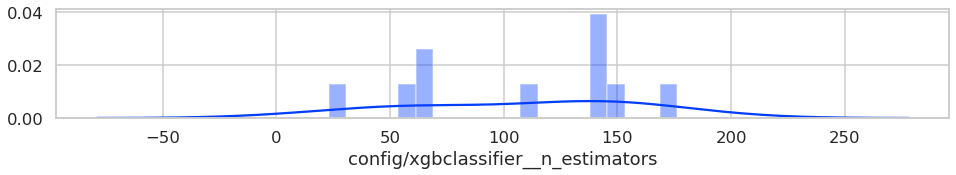

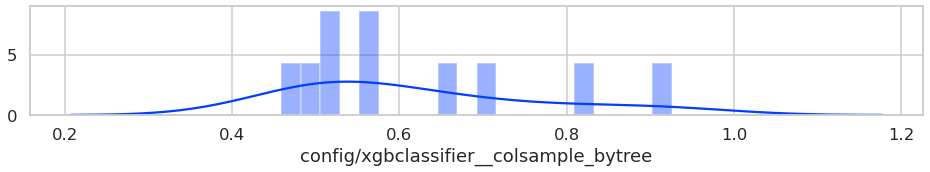

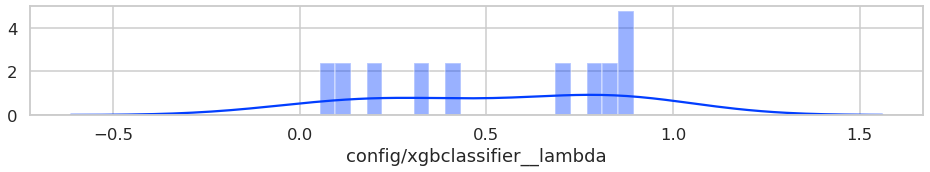

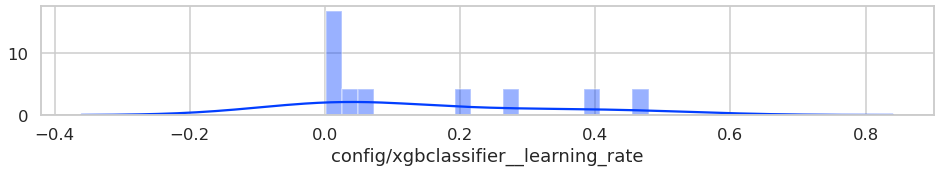

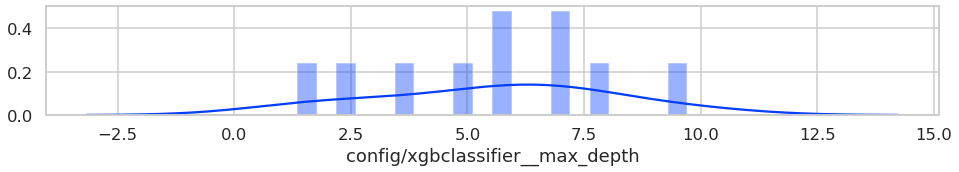

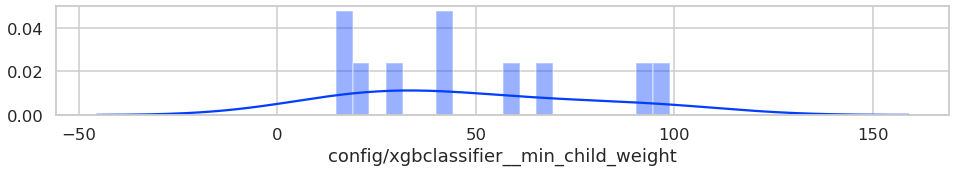

In [15]:
for col in param_cols:
    plt.figure(figsize=(16,2))
    sns.distplot(df[col], bins=20)
    

In [ ]:
%load_ext tensorboard
from tensorboard import notebook 
%tensorboard --logdir "~/ray_results/seg_facies"
notebook.display(height=1000)

In [16]:
ray.shutdown()